In [1]:
import pathlib
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = pathlib.Path("datasets", "housing")

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    pathlib.Path(housing_path).mkdir(parents=True, exist_ok=True)
    tgz_path = pathlib.Path(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH)

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = pathlib.Path(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data(HOUSING_PATH)

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf0d8997c0>,
      dtype=object)

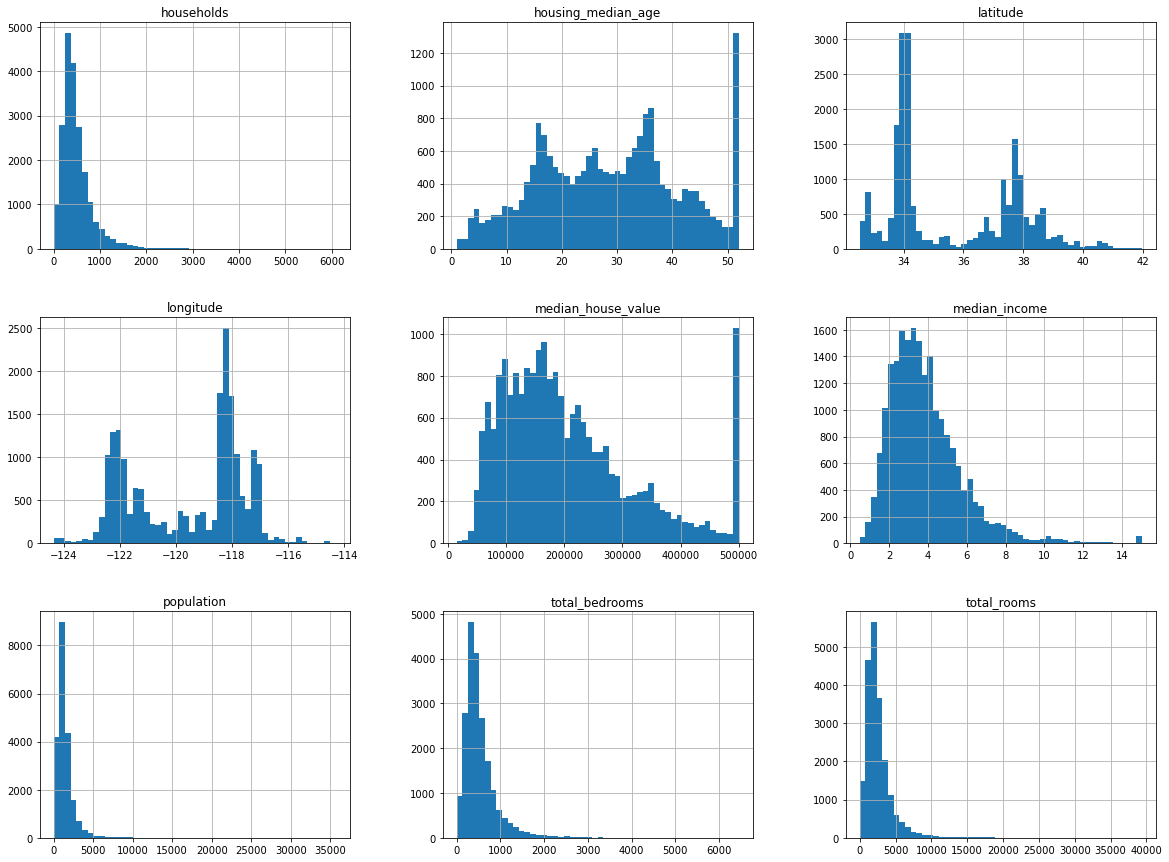

In [9]:
housing.hist(bins=50, figsize=(20,15))

In [10]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)

In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [18]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5])

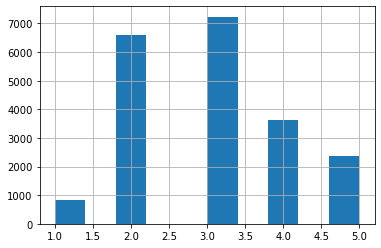

In [19]:
housing["income_cat"].hist()

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [22]:
housing = strat_train_set.copy()

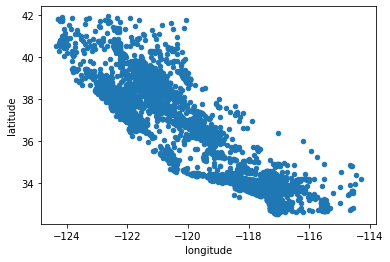

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")

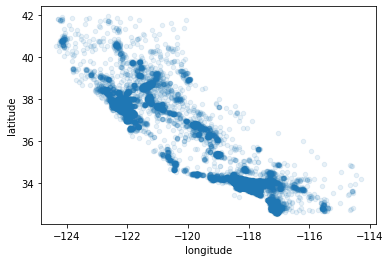

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

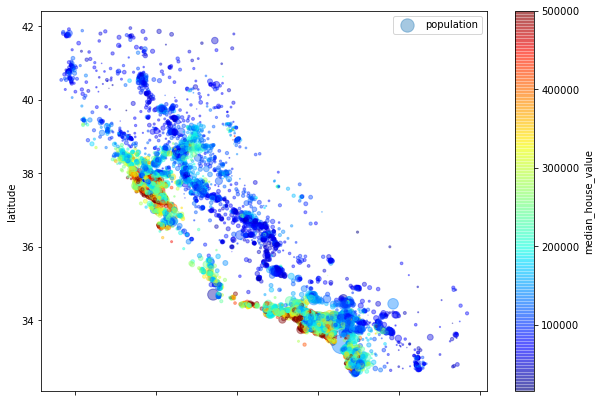

In [25]:
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)

plt.legend()

In [46]:
corr_matrix = housing.corr()

In [50]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf0c8b32e0>,
      dtype=object)

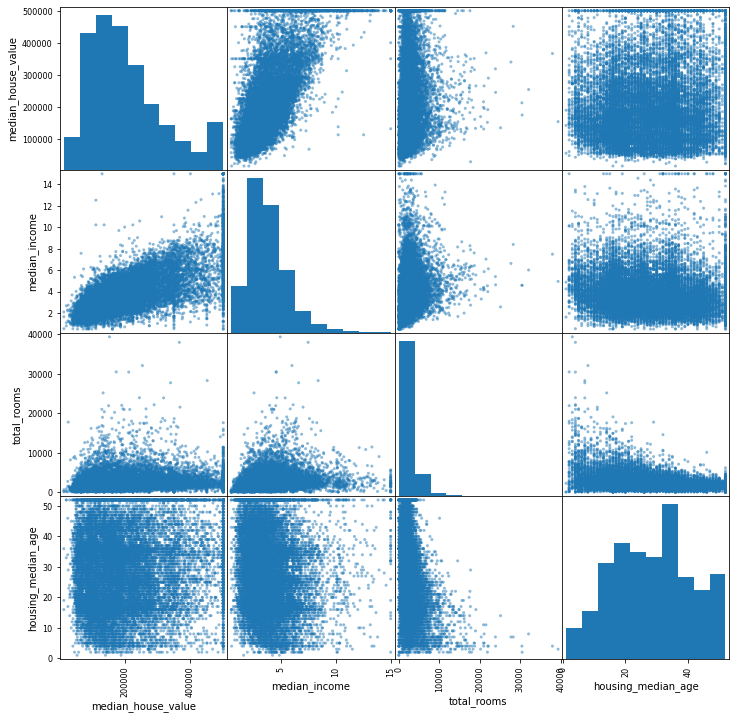

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 12))

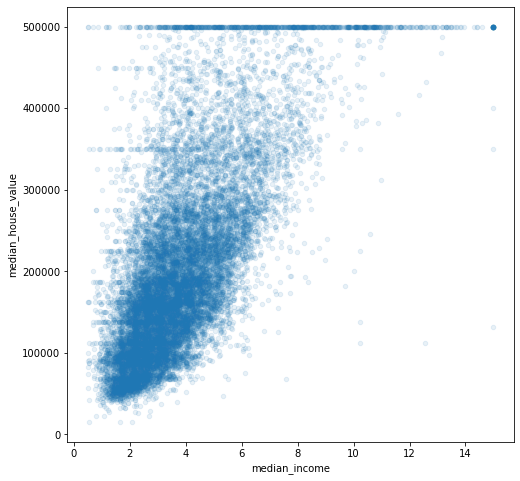

In [55]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(8, 8))

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [59]:
corr_matrix = housing.corr()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5c035de50>,
      dtype=object)

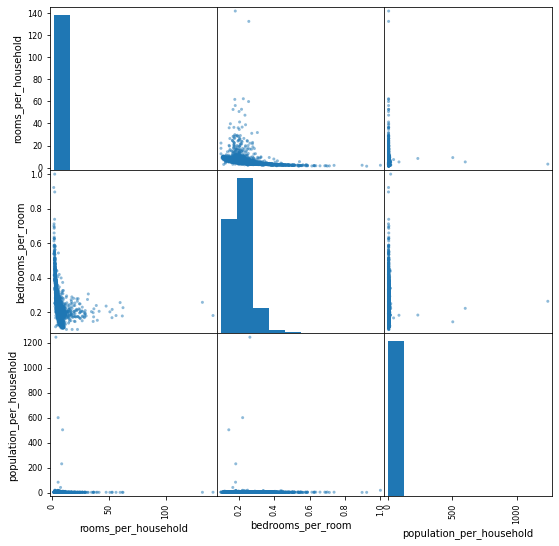

In [64]:
scatter_matrix(
    housing[["rooms_per_household", "bedrooms_per_room", "population_per_household"]], 
    figsize=(9, 9))

In [65]:
>>> corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [28]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [29]:
median = housing["total_bedrooms"].median()

In [30]:
housing["total_bedrooms"].fillna(median, inplace=True)

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [32]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [33]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [98]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [100]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [34]:
X = imputer.transform(housing_num)

In [36]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [37]:
housing_tr.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [38]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [39]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [125]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
cat_encoder = OneHotEncoder()

In [42]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [43]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [132]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),])

In [46]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [116]:
some_data_prepared 

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [47]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),])

housing_prepared = full_pipeline.fit_transform(housing)

In [48]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [49]:
some_data = housing.iloc[:5]

In [50]:
some_labels = housing_labels.iloc[:5]

In [51]:
some_data_prepared = full_pipeline.transform(some_data)

In [52]:
print("Predictions:", np.around(lin_reg.predict(some_data_prepared), decimals=1))

Predictions: [210644.6 317768.8 210956.4  59219.  189747.6]


In [53]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [54]:
from sklearn.metrics import mean_squared_error

In [55]:
housing_predictions = lin_reg.predict(housing_prepared)

In [56]:
lin_mse = mean_squared_error(housing_labels, housing_predictions)

In [57]:
lin_rmse = np.sqrt(lin_mse)

In [58]:
lin_rmse

68628.19819848923

In [59]:
from sklearn.tree import DecisionTreeRegressor

In [60]:
tree_reg = DecisionTreeRegressor()

In [61]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [62]:
housing_predictions = tree_reg.predict(housing_prepared)

In [63]:
tree_mse = mean_squared_error(housing_labels, housing_predictions)

In [66]:
tree_rmse = np.sqrt(tree_mse)

In [67]:
tree_rmse

0.0

In [80]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    tree_reg, 
    housing_prepared, 
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10)

tree_rmse_scores = np.sqrt(abs(scores))

In [81]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("std:", scores.std())

In [82]:
display_scores(tree_rmse_scores)

Scores: [67886.99928254 67245.1900927  70267.39202066 69650.43151665
 72232.36407112 74583.2519684  70466.84946533 71269.38182692
 75622.04667362 69693.73053753]
Mean: 70891.76374554526
std: 2526.1662035099844


In [78]:
scores

array([-4.56267599e+09, -4.47749740e+09, -5.00727902e+09, -4.61347763e+09,
       -5.20980819e+09, -5.61093205e+09, -4.98077125e+09, -5.09501156e+09,
       -6.00901191e+09, -4.88216360e+09])

In [79]:
abs(scores)

array([4.56267599e+09, 4.47749740e+09, 5.00727902e+09, 4.61347763e+09,
       5.20980819e+09, 5.61093205e+09, 4.98077125e+09, 5.09501156e+09,
       6.00901191e+09, 4.88216360e+09])

In [83]:
lin_scores = cross_val_score(
    lin_reg, 
    housing_prepared, 
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10)

In [84]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [85]:
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
std: 2731.674001798349


In [86]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [87]:
forest_scores = cross_val_score(
    forest_reg, 
    housing_prepared, 
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10)

In [88]:
forest_rmse_scores = np.sqrt(-forest_scores)

In [90]:
display_scores(forest_rmse_scores)

Scores: [49268.27271118 47320.67658149 49748.40732885 52463.65217256
 49537.64111563 53495.86890684 48830.22188424 47964.96685774
 53276.37442748 50268.39355441]
Mean: 50217.447554041304
std: 2052.4503815981325


In [92]:
from sklearn.model_selection import GridSearchCV

In [94]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

In [95]:
forest_reg = RandomForestRegressor()

In [97]:
grid_search = GridSearchCV(
    forest_reg, 
    param_grid, cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [98]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [99]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [100]:
cvres = grid_search.cv_results_

In [104]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.around(np.sqrt(-mean_score), decimals=2), params)

63977.14 {'max_features': 2, 'n_estimators': 3}
55326.56 {'max_features': 2, 'n_estimators': 10}
52864.98 {'max_features': 2, 'n_estimators': 30}
61148.37 {'max_features': 4, 'n_estimators': 3}
53703.38 {'max_features': 4, 'n_estimators': 10}
50332.09 {'max_features': 4, 'n_estimators': 30}
60136.45 {'max_features': 6, 'n_estimators': 3}
52326.59 {'max_features': 6, 'n_estimators': 10}
50020.64 {'max_features': 6, 'n_estimators': 30}
58481.54 {'max_features': 8, 'n_estimators': 3}
52241.18 {'max_features': 8, 'n_estimators': 10}
49865.38 {'max_features': 8, 'n_estimators': 30}
62476.21 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54154.61 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60386.27 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52643.84 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58913.57 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
52367.23 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


In [105]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.94535854e-02, 6.30423719e-02, 4.31172717e-02, 1.51628882e-02,
       1.47233087e-02, 1.45410544e-02, 1.47708864e-02, 3.59241870e-01,
       4.31345834e-02, 1.12724200e-01, 8.62022274e-02, 1.24156601e-02,
       1.45541384e-01, 1.92547703e-05, 2.23193524e-03, 3.67751934e-03])

In [106]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.35924186978004624, 'median_income'),
 (0.14554138365287128, 'INLAND'),
 (0.11272419956626281, 'pop_per_hhold'),
 (0.08620222740871461, 'bedrooms_per_room'),
 (0.06945358539633589, 'longitude'),
 (0.0630423718765985, 'latitude'),
 (0.04313458343581212, 'rooms_per_hhold'),
 (0.043117271691399346, 'housing_median_age'),
 (0.015162888238548002, 'total_rooms'),
 (0.014770886363808805, 'households'),
 (0.014723308733763278, 'total_bedrooms'),
 (0.014541054384660865, 'population'),
 (0.012415660114730795, '<1H OCEAN'),
 (0.0036775193427792405, 'NEAR OCEAN'),
 (0.0022319352434096956, 'NEAR BAY'),
 (1.9254770258474484e-05, 'ISLAND')]

In [118]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [120]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
# => evaluates to 47,730.2

In [121]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(
    confidence, 
    len(squared_errors) - 1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors)))

array([45646.82429377, 49508.77274725])